# Comparison between with and without offset model

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 116.91s elapsed
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 115.05s elapsed


C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


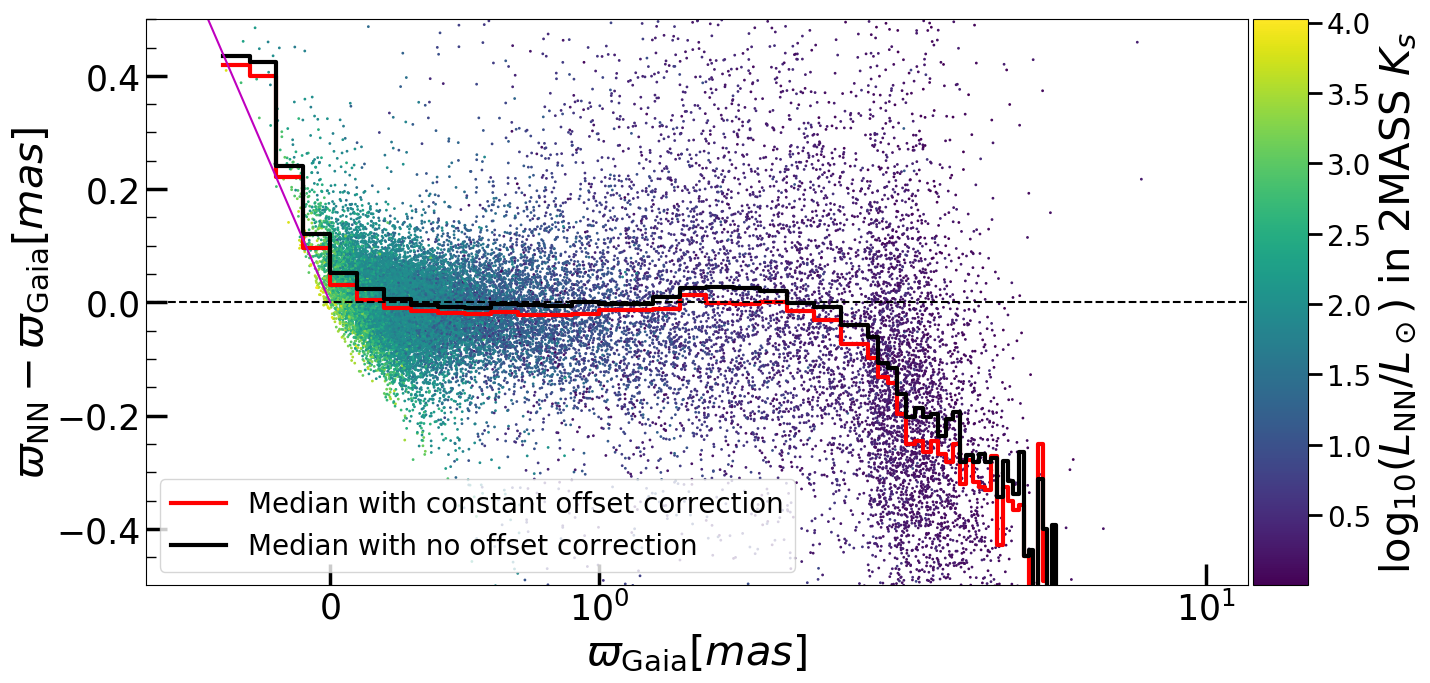

In [1]:
%matplotlib inline
from astroNN.models import load_folder
from astroNN.nn.numpy import median_absolute_percentage_error as mape
from astroNN.gaia import mag_to_fakemag, fakemag_to_pc, fakemag_to_logsol, fakemag_to_parallax
import h5py
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

with h5py.File('gaia_dr2_test.h5', 'r') as F:
    spectra = np.array(F['spectra'])
    parallax = np.array(F['parallax'])
    parallax_err = np.array(F['parallax_err'])
    corrected_K = np.array(F['corrected_K'])
    
net = load_folder("astroNN_constant_model_reduced")
pred, pred_error = net.test(spectra)

net2 = load_folder("astroNN_no_offset_model")
pred2, pred2_error = net2.test(spectra)

logsol = fakemag_to_logsol(pred[:, 0])

above_solar = (logsol > 0)

number_bin = 55
low_parallax = -0.5
high_parallax= 5
median_diff = []
median_diff2 = []
spaces_dist = np.linspace(low_parallax, high_parallax, number_bin+1)

residue = (fakemag_to_parallax(pred[:, 0], corrected_K).value - parallax - 0.052)[above_solar]
residue2 = (fakemag_to_parallax(pred2[:, 0], corrected_K).value - parallax)[above_solar]

for i in range(number_bin):
    idx = ((parallax[above_solar]<spaces_dist[i+1]) & (parallax[above_solar]>spaces_dist[i]))
    median_diff.append(np.median(residue[idx]))
    median_diff2.append(np.median(residue2[idx]))

f, ax = plt.subplots(1, figsize=(15,7.5), dpi=100)
ax.semilogx(spaces_dist[:-1], np.array(median_diff), ls='steps-post', linewidth=3., c='r', label='Median with constant offset correction')
ax.semilogx(spaces_dist[:-1], np.array(median_diff2), ls='steps-post', linewidth=3., c='k', label='Median with no offset correction')
mappable = ax.scatter(parallax[above_solar], residue, c=logsol[above_solar], s=1., rasterized=True)
ax.set_xscale('symlog')
ax.axhline(0., ls='--', c='k')
ax.plot([0, -0.5], [0.0, 0.55], c='m')
ax.set_xlabel(r'$ \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylabel(r'$\varpi_{\mathrm{NN}} - \varpi_{\mathrm{Gaia}} [$\mathrm{mas}$]$', fontsize=30)
ax.set_ylim(-0.5, 0.5)
ax.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"$\log_{10} (L_\mathrm{NN} /L_\odot)$" + " in 2MASS " + r"$K_{s}$", size=30)
ax.minorticks_on()
ax.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax.tick_params(width=1, length=7, which='minor')
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
# plt.savefig("result_offset_median.pdf")

# Get constant offset model posterior

Getting posterior from offset model is not trivial and the following code shows how to do it.

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

In [1]:
import numpy as np

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_constant_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

# To get offset posterior
# 1.412.... is a normalization factor used during training, so here we denormalize it and convert it to uas by *1000
offset = model.predict({'input': np.ones((1000, 7518, 1)), 'labels_err': np.ones((1000, 1)), 
                        'input_err': np.ones((1000, 7518, 1))}) * 1.4124689064768827 * 1000
mean, std = np.mean(offset), np.std(offset)
print(f"Offset: {mean:.1f}+/-{std:.1f}")

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
Offset: -52.3+/-2.0


# Get multivariate offset model posterior

Getting posterior from offset model is not trivial just by using ``astroNN`` and the following code shows how to do it, sampling 10 times

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
DP_RP:  [  2.26327509 -11.37192291 -37.1688481 ] [0.00325802 0.04660171 0.0381725 ]
G mag:  [  0.92594424 -28.86177363 173.18443705] [2.08827721e-04 1.71000287e-01 8.72034622e+00]
T_eff:  [ 5.95356338e-06 -4.89327920e-02  4.82596262e+01] [3.08715150e-14 2.79843938e-06 1.58588509e+01]

Plane fit parameter:  [ -0.06353528  -1.86137234   3.23487186  -6.19925706 -39.90097709
  46.16631091]
Parameter uncertainty:  [7.23515671e-05 6.29664848e-04 6.84213462e-04 4.27036329e-02
 9.74729880e-02 1.60096031e+00]


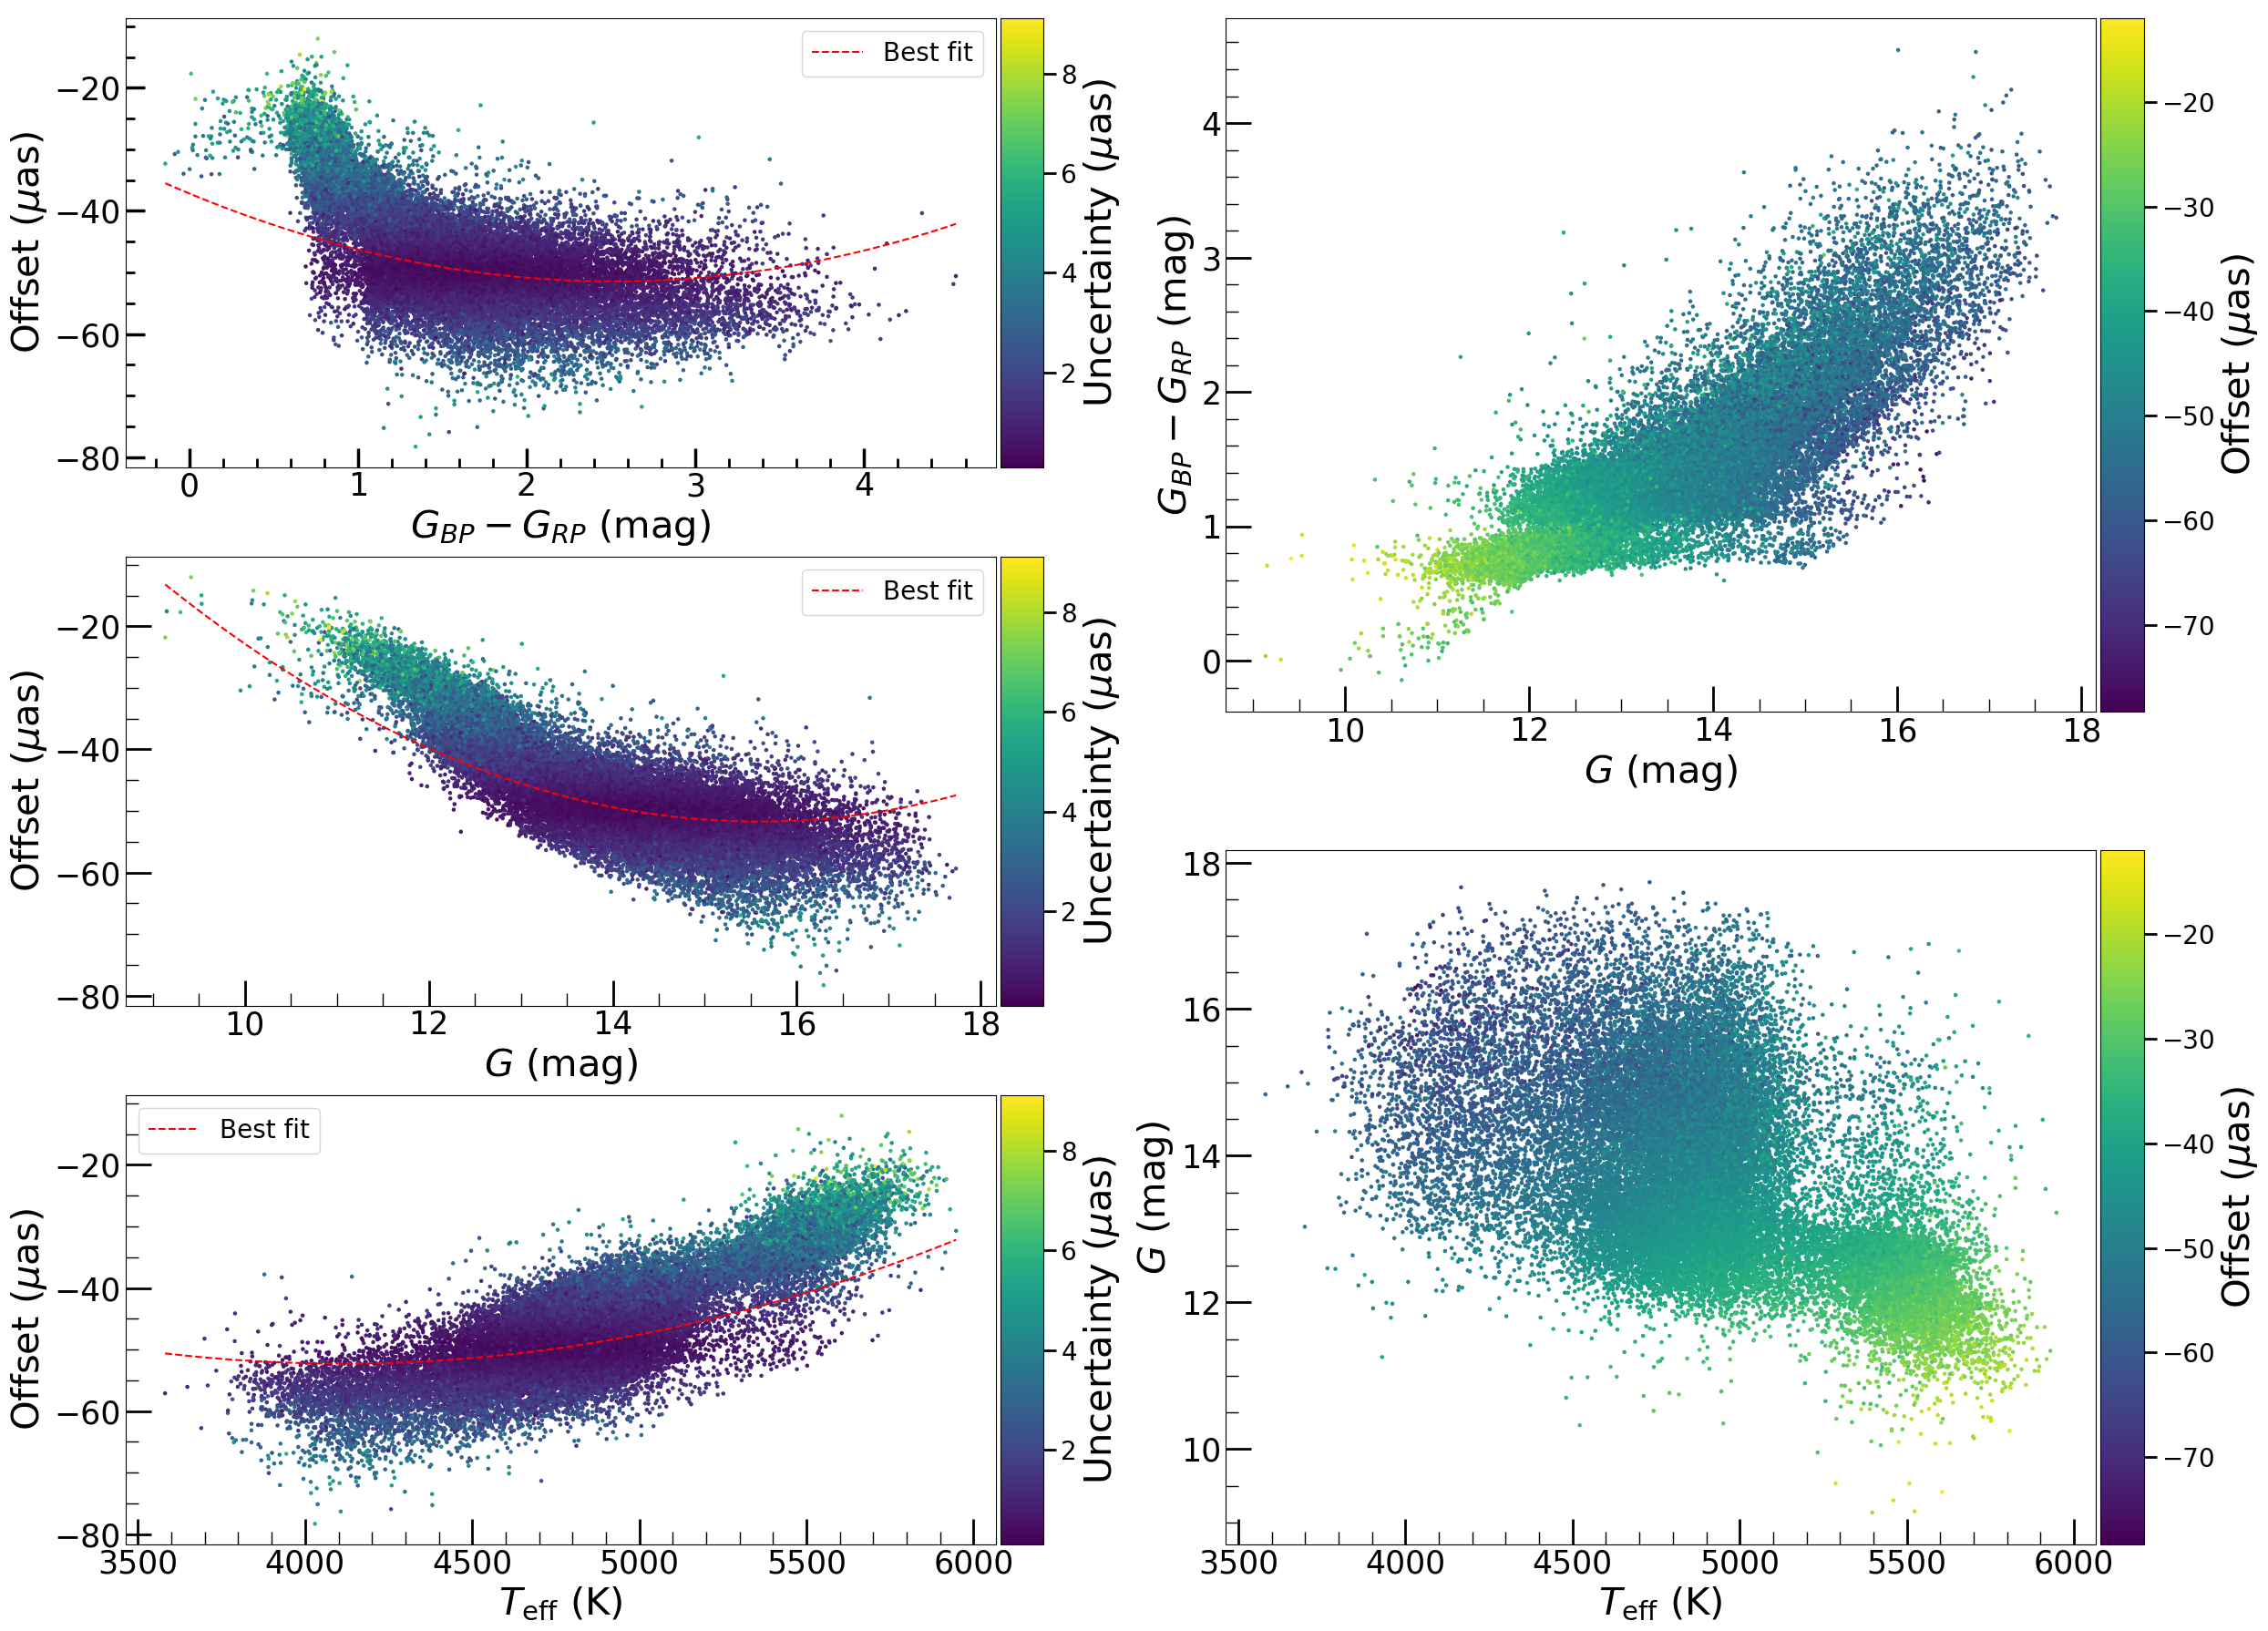

In [1]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

# To get offset posterior, sample 10 times
# 1.412.... is a normalization factor used during training, so here we denormalize it and convert it to uas by *1000
offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]

# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]
z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
# numpy bug?? need to add 0.5K gaussian to get around teff polyfir error
z_teff, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape), result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
p_bp_rp = np.poly1d(z_bp_rp)
p_g = np.poly1d(z_g)
p_teff = np.poly1d(z_teff)

def func(x, a, b, c, d, e, f):
    return a*x[0]**2 + b*x[1]**2 + c*x[0]*x[1] + d*x[0] + e*x[1] + f

# def func(x, a, b, c):
#     return a*x[0] + b*x[1] + c

pall, pall_cov = curve_fit(func, (phot_g_mean_mag, bp_rp), result, 
                           sigma=offset_uncertainty, absolute_sigma=True)

fig = plt.figure(figsize=(25, 18), dpi=100)
gs = gridspec.GridSpec(1, 2)
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
inner2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax0 = plt.Subplot(fig, inner1[0])
ax1 = plt.Subplot(fig, inner1[1])
ax2 = plt.Subplot(fig, inner1[2])
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

mappable = ax0.scatter(bp_rp, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(bp_rp), np.max(bp_rp), 1000)
ax0.plot(samples, p_bp_rp(samples), c='r', ls='--', label='Best fit')
ax0.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax0.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax0.minorticks_on()
ax0.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax0.tick_params(width=2, length=7, which='minor')
ax0.xaxis.set_tick_params(direction='in', which='both')
ax0.yaxis.set_tick_params(direction='in', which='both')
ax0.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax1.scatter(phot_g_mean_mag, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(phot_g_mean_mag), np.max(phot_g_mean_mag), 1000)
ax1.plot(samples, p_g(samples), c='r', ls='--', label='Best fit')
ax1.set_xlabel(r"$G$ (mag)", fontsize=30)
ax1.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax1.minorticks_on()
ax1.tick_params(labelsize=25, width=2, length=20, which='major')
ax1.tick_params(width=1, length=10, which='minor')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax1.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax2.scatter(teff, result, c=offset_uncertainty, s=5., rasterized=True)
samples_norm = np.linspace(np.min(teff), np.max(teff), 1000)
samples = np.linspace(np.min(teff), np.max(teff), 1000)
ax2.plot(samples, p_teff(samples_norm), c='r', ls='--', label='Best fit')
ax2.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax2.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax2.minorticks_on()
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax2.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax3.scatter(phot_g_mean_mag, bp_rp, c=result, s=5., rasterized=True)
ax3.set_xlabel(r"$G$ (mag)", fontsize=30)
ax3.set_ylabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax3.minorticks_on()
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)

mappable = ax4.scatter(teff, phot_g_mean_mag, c=result, s=5., rasterized=True)
ax4.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax4.set_ylabel(r"$G$ (mag)", fontsize=30)
ax4.minorticks_on()
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')
ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)

fig.add_subplot(ax0)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)

fig.tight_layout()
plt.savefig("result_offset.pdf")

print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("G mag: ", z_g, np.diag(cov_g))
print("T_eff: ", z_teff, np.diag(cov_teff))

print("\nPlane fit parameter: ", pall)
print("Parameter uncertainty: ", np.diag(pall_cov))

Sandard Dv:  5.617553261517918


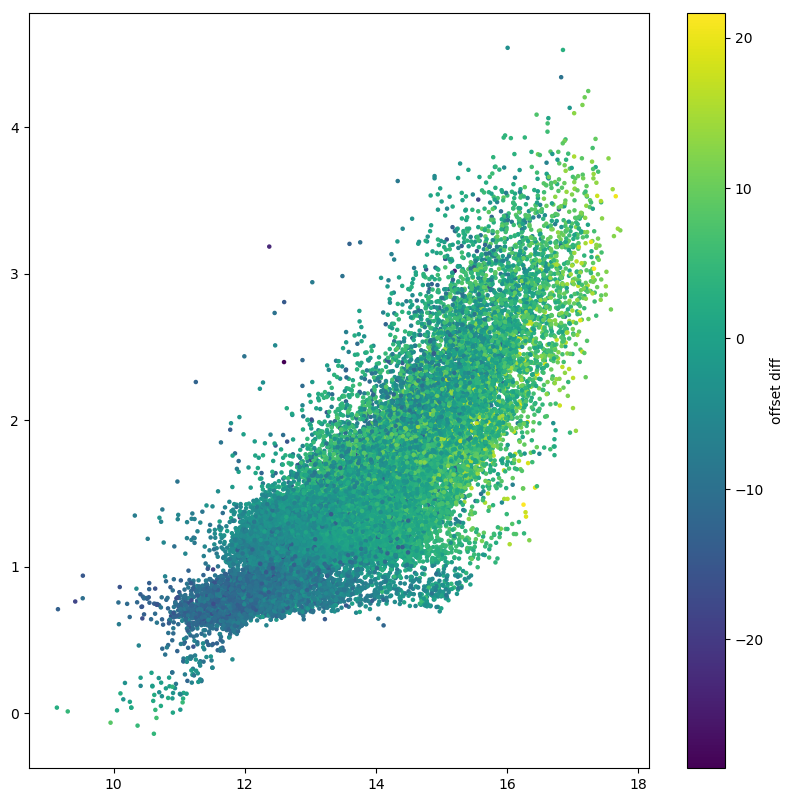

In [2]:
%matplotlib inline
import pylab as plt
import numpy as np
import h5py

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

fig = plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(phot_g_mean_mag, bp_rp, c=func([phot_g_mean_mag, bp_rp], *pall) - result, s=5.)
cbar = plt.colorbar()
cbar.set_label("offset diff")

print("Sandard Dv: ", np.std(func([phot_g_mean_mag, bp_rp], *pall) - result))

## Gaia offset for APOGEE RC

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
E:\sdss_mirror\dr14/apogee/vac/apogee-rc/cat/apogee-rc-DR14.fits was found!
DP_RP:  [  2.01561648  -8.55315962 -40.47528335] [0.00937507 0.13436867 0.11240869]
G mag:  [  0.34814506 -10.40698017  27.93401847] [9.22680634e-05 6.94129130e-02 3.23921227e+00]
T_eff:  [ 2.88948114e-05 -2.60076709e-01  5.33645192e+02] [1.46585028e-12 1.34206264e-04 7.67643481e+02]

Plane fit parameter:  [ 0.32470438  1.04490482 -0.36078805 -9.37337694  2.28100289 19.729105  ]
Parameter uncertainty:  [1.77846798e-05 1.74000583e-03 5.99575794e-04 7.45118675e-03
 5.69322640e-02 2.33656216e-01]
RC median offset:  -45.22816 mas


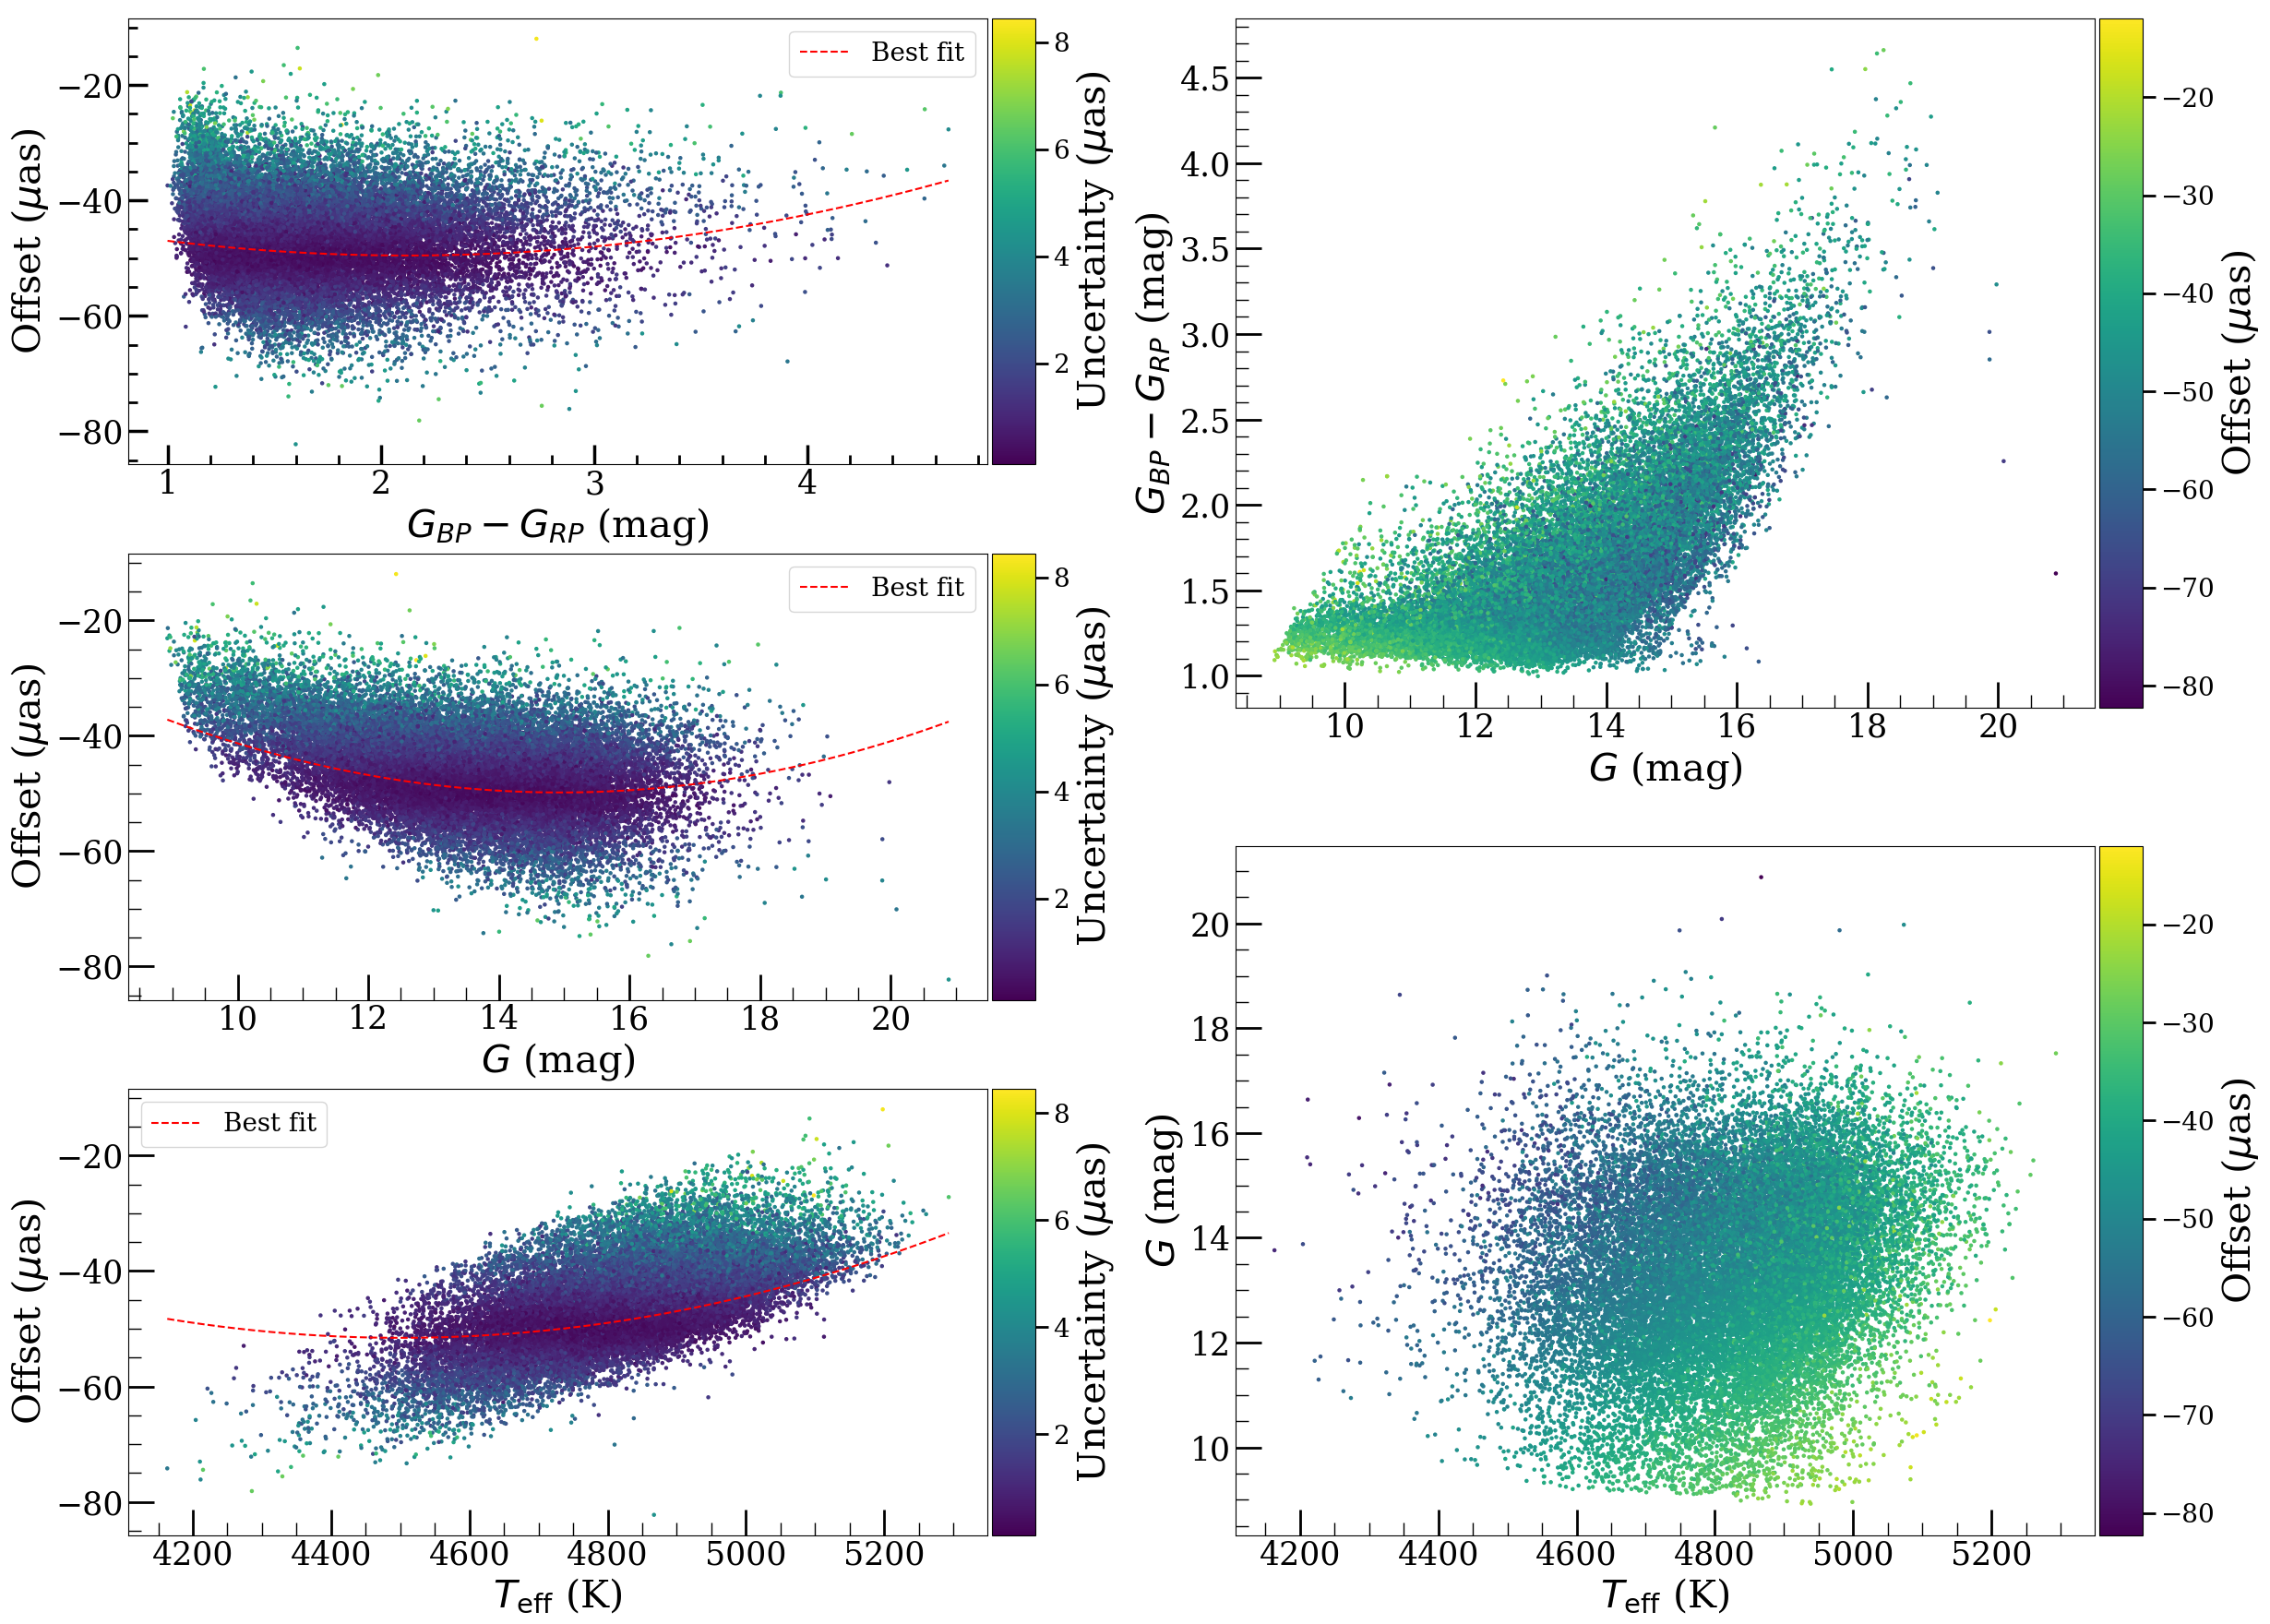

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

from astropy.io import fits
from astropy.stats import mad_std

from astroNN.nn.numpy import median_absolute_percentage_error
from astroNN.apogee import allstar
from astroNN.datasets import xmatch
from astroNN.datasets import load_apogee_distances, load_apogee_rc
from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

gaia_data_file = fits.getdata("apogeedr14_gaiadr2_xmatch.fits")
bp_rp=gaia_data_file['bp_rp']
phot_g_mean_mag=gaia_data_file['phot_g_mean_mag']

astroNN_data = fits.getdata("apogee_dr14_nn_dist.fits")
apogee_id = astroNN_data['APOGEE_ID']
ra = astroNN_data['RA']
dec = astroNN_data['DEC']
astroNN_pc = astroNN_data['pc']
astroNN_pc_error = astroNN_data['pc_error']
good_idx = ((astroNN_pc_error!=-9999.) & (astroNN_pc / astroNN_pc_error > 5) & (phot_g_mean_mag!=-9999.) & (bp_rp!=-9999.))

astroNN_teff = teff = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 0][good_idx]
astroNN_logg = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 1][good_idx]

# red clumps
rc_RA, rc_DEC, rc_pc = load_apogee_rc(dr=14, metric='distance')
non_rc_ra = np.genfromtxt("apogee_non_rc_ra.txt")  # RC contemination from NN logg comparison
ele, idx1, idx2 = np.intersect1d(non_rc_ra, rc_RA, return_indices=True)  # cross-match
rc_RA = np.delete(rc_RA, idx2)
rc_DEC = np.delete(rc_DEC, idx2)
rc_pc = np.delete(rc_pc, idx2)
idx5, idx6, sep = xmatch(ra[good_idx], rc_RA, colRA1=ra[good_idx], colDec1=dec[good_idx], colRA2=rc_RA, colDec2=rc_DEC, swap=False)

astroNN_teff = astroNN_teff[idx5]
teff = teff[idx5]
bp_rp=gaia_data_file['bp_rp'][good_idx][idx5]
phot_g_mean_mag=gaia_data_file['phot_g_mean_mag'][good_idx][idx5]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]
# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]
z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
# numpy bug?? need to add 0.5K gaussian to get around teff
z_teff, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape), result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
p_bp_rp = np.poly1d(z_bp_rp)
p_g = np.poly1d(z_g)
p_teff = np.poly1d(z_teff)

def func(x, a, b, c, d, e, f):
    return a*x[0]**2 + b*x[1]**2 + c*x[0]*x[1] + d*x[0] + e*x[1] + f

pall, pall_cov = curve_fit(func, (phot_g_mean_mag, bp_rp), result, 
                           sigma=offset_uncertainty, absolute_sigma=True)

fig = plt.figure(figsize=(25, 18), dpi=100)
gs = gridspec.GridSpec(1, 2)
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
inner2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax0 = plt.Subplot(fig, inner1[0])
ax1 = plt.Subplot(fig, inner1[1])
ax2 = plt.Subplot(fig, inner1[2])
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

mappable = ax0.scatter(bp_rp, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(bp_rp), np.max(bp_rp), 1000)
ax0.plot(samples, p_bp_rp(samples), c='r', ls='--', label='Best fit')
ax0.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax0.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax0.minorticks_on()
ax0.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax0.tick_params(width=2, length=7, which='minor')
ax0.xaxis.set_tick_params(direction='in', which='both')
ax0.yaxis.set_tick_params(direction='in', which='both')
ax0.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax1.scatter(phot_g_mean_mag, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(phot_g_mean_mag), np.max(phot_g_mean_mag), 1000)
ax1.plot(samples, p_g(samples), c='r', ls='--', label='Best fit')
ax1.set_xlabel(r"$G$ (mag)", fontsize=30)
ax1.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax1.minorticks_on()
ax1.tick_params(labelsize=25, width=2, length=20, which='major')
ax1.tick_params(width=1, length=10, which='minor')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax1.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax2.scatter(teff, result, c=offset_uncertainty, s=5., rasterized=True)
samples_norm = np.linspace(np.min(teff), np.max(teff), 1000)
samples = np.linspace(np.min(teff), np.max(teff), 1000)
ax2.plot(samples, p_teff(samples_norm), c='r', ls='--', label='Best fit')
ax2.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax2.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax2.minorticks_on()
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax2.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax3.scatter(phot_g_mean_mag, bp_rp, c=result, s=5., rasterized=True)
ax3.set_xlabel(r"$G$ (mag)", fontsize=30)
ax3.set_ylabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax3.minorticks_on()
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)

mappable = ax4.scatter(teff, phot_g_mean_mag, c=result, s=5., rasterized=True)
ax4.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax4.set_ylabel(r"$G$ (mag)", fontsize=30)
ax4.minorticks_on()
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')
ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)

fig.add_subplot(ax0)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)

fig.tight_layout()
plt.savefig("result_RC_offset.pdf")

print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("G mag: ", z_g, np.diag(cov_g))
print("T_eff: ", z_teff, np.diag(cov_teff))

print("\nPlane fit parameter: ", pall)
print("Parameter uncertainty: ", np.diag(pall_cov))

print("RC median offset: ", np.median(result), "mas")